# 电影评分的 k 均值聚类

假设你是 Netflix 的一名数据分析师，你想要根据用户对不同电影的评分研究用户在电影品位上的相似和不同之处。了解这些评分对用户电影推荐系统有帮助吗？我们来研究下这方面的数据。

我们将使用的数据来自精彩的 [MovieLens](https://movielens.org/) [用户评分数据集](https://grouplens.org/datasets/movielens/)。我们稍后将在 notebook 中查看每个电影评分，先看看不同类型之间的评分比较情况。

## 数据集概述
该数据集有两个文件。我们将这两个文件导入 pandas dataframe 中：

In [81]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.sparse import csr_matrix
import helper

# Import the Movies dataset
movies = pd.read_csv('ml-latest-small/movies.csv')
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


<div>
<style>
    .dataframe thead tr:only-child th {
        text-align: right;
    }

In [82]:
# Import the ratings dataset
ratings = pd.read_csv('ml-latest-small/ratings.csv')
ratings.head()

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205


<div>
<style>
    .dataframe thead tr:only-child th {
        text-align: right;
    }

现在我们已经知道数据集的结构，每个表格中有多少条记录?

In [83]:
print('The dataset contains: ', len(ratings), ' ratings of ', len(movies), ' movies.')

The dataset contains:  100004  ratings of  9125  movies.


## 爱情片与科幻片
我们先查看一小部分用户，并看看他们喜欢什么类型的电影。我们将大部分数据预处理过程都隐藏在了辅助函数中，并重点研究聚类概念。在完成此 notebook 后，建议你快速浏览下 helper.py，了解这些辅助函数是如何实现的。

In [84]:
# Calculate the average rating of romance and scifi movies
genre_ratings = helper.get_genre_ratings(ratings, movies, ['Romance', 'Sci-Fi'], ['avg_romance_rating', 'avg_scifi_rating'])
genre_ratings.head()

,avg_romance_rating,avg_scifi_rating
userId,,
1,3.50,2.40
2,3.59,3.80
3,3.65,3.14
4,4.50,4.26
5,4.08,4.00


<div>
<style>
    .dataframe thead tr:only-child th {
        text-align: right;
    }

函数 `get_genre_ratings` 计算了每位用户对所有爱情片和科幻片的平均评分。我们对数据集稍微进行偏倚，删除同时喜欢科幻片和爱情片的用户，使聚类能够将他们定义为更喜欢其中一种类型。

In [85]:
biased_dataset = helper.bias_genre_rating_dataset(genre_ratings, 3.2, 2.5)

print( "Number of records: ", len(biased_dataset))
biased_dataset.head()

Number of records:  183


,userId,avg_romance_rating,avg_scifi_rating
0,1,3.50,2.40
1,3,3.65,3.14
2,6,2.90,2.75
3,7,2.93,3.36
4,12,2.89,2.62


<div>
<style>
    .dataframe thead tr:only-child th {
        text-align: right;
    }

可以看出我们有 183 位用户，对于每位用户，我们都得出了他们对看过的爱情片和科幻片的平均评分。

我们来绘制该数据集：

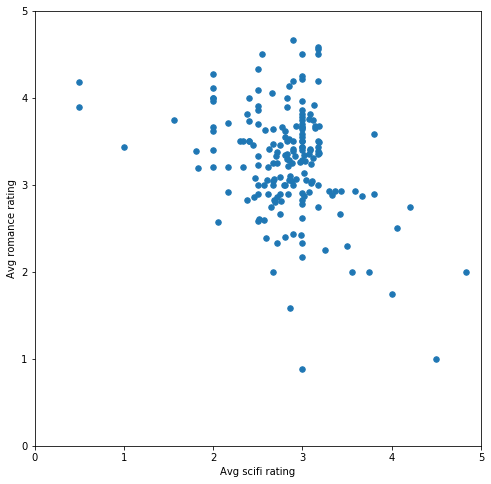

In [86]:
%matplotlib inline


helper.draw_scatterplot(biased_dataset['avg_scifi_rating'],'Avg scifi rating', biased_dataset['avg_romance_rating'], 'Avg romance rating')

我们可以在此样本中看到明显的偏差（我们故意创建的）。如果使用 k 均值将样本分成两组，效果如何？

In [87]:
# Let's turn our dataset into a list
X = biased_dataset[['avg_scifi_rating','avg_romance_rating']].values

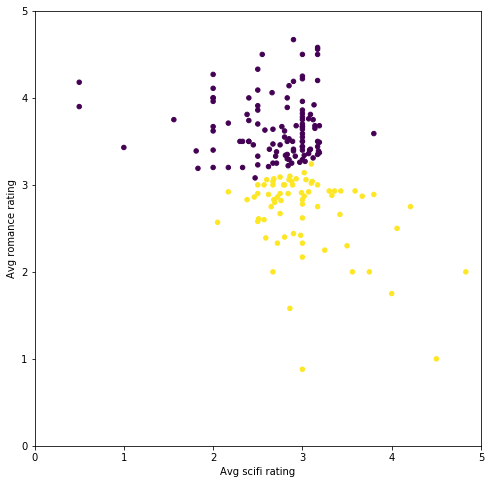

In [88]:
# TODO: Import KMeans
from sklearn.cluster import KMeans 

# TODO: Create an instance of KMeans to find two clusters
kmeans_1 = KMeans(n_clusters=2)

# TODO: use fit_predict to cluster the dataset
predictions = kmeans_1.fit_predict(X) 

# Plot
helper.draw_clusters(biased_dataset, predictions)

可以看出分组的依据主要是每个人对爱情片的评分高低。如果爱情片的平均评分超过 3 星，则属于第一组，否则属于另一组。

如果分成三组，会发生什么？

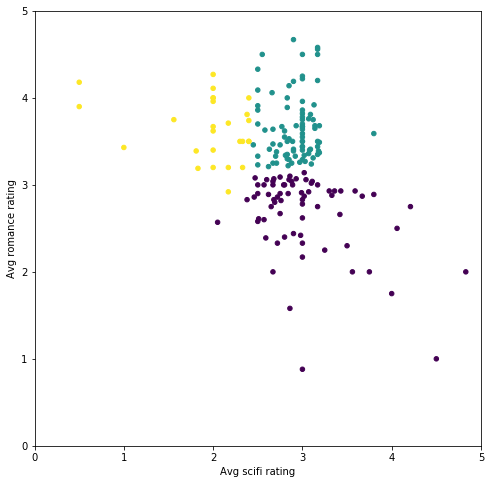

In [89]:
# TODO: Create an instance of KMeans to find three clusters
kmeans_2 = KMeans(n_clusters=3)

# TODO: use fit_predict to cluster the dataset
predictions_2 = kmeans_2.fit_predict(X)

# Plot
helper.draw_clusters(biased_dataset, predictions_2)

现在平均科幻片评分开始起作用了，分组情况如下所示：

 * 喜欢爱情片但是不喜欢科幻片的用户
 * 喜欢科幻片但是不喜欢爱情片的用户
 * 即喜欢科幻片又喜欢爱情片的用户

再添加一组

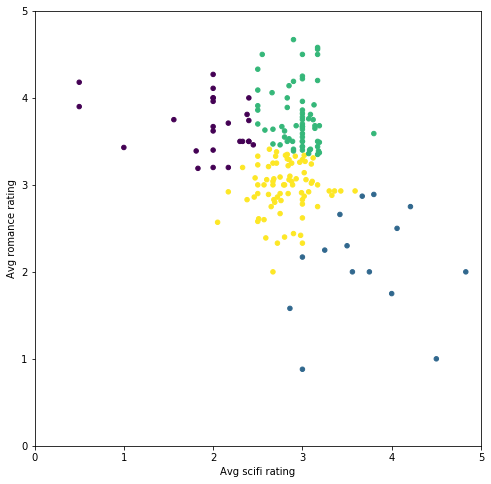

In [90]:
# TODO: Create an instance of KMeans to find three clusters
kmeans_3 = KMeans(n_clusters=4)

# TODO: use fit_predict to cluster the dataset
predictions_3 = kmeans_3.fit_predict(X)

# Plot
helper.draw_clusters(biased_dataset, predictions_3)

可以看出将数据集分成的聚类越多，每个聚类中用户的兴趣就相互之间越相似。

## 选择 K
我们可以将数据点拆分为任何数量的聚类。对于此数据集来说，正确的聚类数量是多少？

可以通过[多种](https://en.wikipedia.org/wiki/Determining_the_number_of_clusters_in_a_data_set)方式选择聚类 k。我们将研究一种简单的方式，叫做“肘部方法”。肘部方法会绘制 k 的上升值与使用该 k 值计算的总误差分布情况。

如何计算总误差？
一种方法是计算平方误差。假设我们要计算 k=2 时的误差。有两个聚类，每个聚类有一个“图心”点。对于数据集中的每个点，我们将其坐标减去所属聚类的图心。然后将差值结果取平方（以便消除负值），并对结果求和。这样就可以获得每个点的误差值。如果将这些误差值求和，就会获得 k=2 时所有点的总误差。

现在的一个任务是对每个 k（介于 1 到数据集中的元素数量之间）执行相同的操作。

In [91]:

df = biased_dataset[['avg_scifi_rating','avg_romance_rating']]

# Choose the range of k values to test.
# We added a stride of 5 to improve performance. We don't need to calculate the error for every k value
possible_k_values = range(2, len(X)+1, 5)

# Calculate error values for all k values we're interested in
errors_per_k = [helper.clustering_errors(k, X) for k in possible_k_values]


In [92]:
# Optional: Look at the values of K vs the silhouette score of running K-means with that value of k
list(zip(possible_k_values, errors_per_k))

[(2, 0.35588178764728268),
 (7, 0.37279383320980264),
 (12, 0.3518698343240218),
 (17, 0.37820875809180354),
 (22, 0.36868493468308944),
 (27, 0.36823340471911153),
 (32, 0.36307149425621021),
 (37, 0.37901614926817367),
 (42, 0.37976528086416311),
 (47, 0.3755461755212216),
 (52, 0.36250979310418729),
 (57, 0.36146087578717356),
 (62, 0.34567907493611405),
 (67, 0.32824622466620584),
 (72, 0.35889609412438994),
 (77, 0.34552717937460076),
 (82, 0.33121407779757595),
 (87, 0.3322913825848981),
 (92, 0.3172579872158644),
 (97, 0.31955881425396387),
 (102, 0.31181584269198265),
 (107, 0.30625918784981243),
 (112, 0.29928846662239933),
 (117, 0.28149896732898255),
 (122, 0.26426601987908183),
 (127, 0.25130412692540771),
 (132, 0.24129665462038008),
 (137, 0.2215932999968542),
 (142, 0.2170514151993769),
 (147, 0.20986641664298977),
 (152, 0.17994016612576225),
 (157, 0.16529806145320275),
 (162, 0.14665676290123009),
 (167, 0.12609539969223341),
 (172, 0.10075966098920461),
 (177, 0.0642

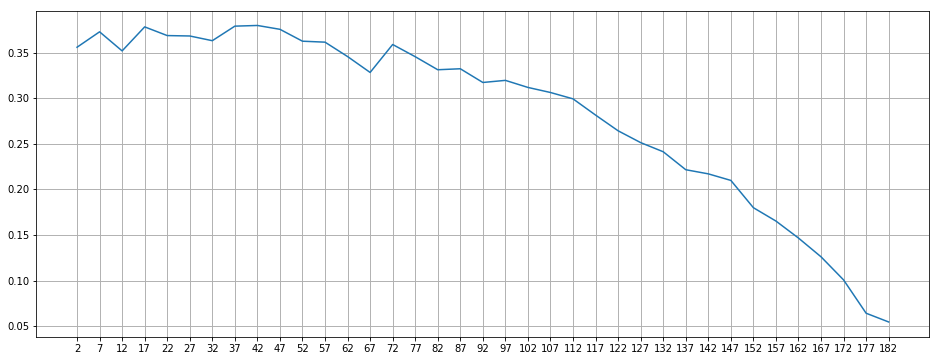

In [93]:
# Plot the each value of K vs. the silhouette score at that value
fig, ax = plt.subplots(figsize=(16, 6))
plt.plot(possible_k_values, errors_per_k)

# Ticks and grid
xticks = np.arange(min(possible_k_values), max(possible_k_values)+1, 5.0)
ax.set_xticks(xticks, minor=False)
ax.set_xticks(xticks, minor=True)
ax.xaxis.grid(True, which='both')
yticks = np.arange(round(min(errors_per_k), 2), max(errors_per_k), .05)
ax.set_yticks(yticks, minor=False)
ax.set_yticks(yticks, minor=True)
ax.yaxis.grid(True, which='both')

看了该图后发现，合适的 k 值包括 7、22、27、32 等（每次运行时稍微不同）。聚类  (k) 数量超过该范围将开始导致糟糕的聚类情况（根据轮廓分数）

我会选择 k=7，因为更容易可视化：

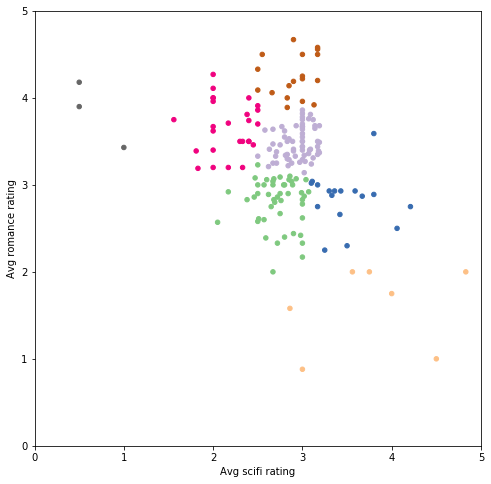

In [94]:
# TODO: Create an instance of KMeans to find seven clusters
kmeans_4 = KMeans(n_clusters=7)

# TODO: use fit_predict to cluster the dataset
predictions_4 = kmeans_4.fit_predict(X)

# Plot
helper.draw_clusters(biased_dataset, predictions_4, cmap='Accent')

注意：当你尝试绘制更大的 k 值（超过 10）时，需要确保你的绘制库没有对聚类重复使用相同的颜色。对于此图，我们需要使用 [matplotlib colormap](https://matplotlib.org/examples/color/colormaps_reference.html) `Accent`，因为其他色图要么颜色之间的对比度不强烈，要么在超过 8 个或 10 个聚类后会重复利用某些颜色。


## 再加入动作片类型
到目前为止，我们只查看了用户如何对爱情片和科幻片进行评分。我们再添加另一种类型，看看加入动作片类型后效果如何。

现在数据集如下所示：

In [95]:
biased_dataset_3_genres = helper.get_genre_ratings(ratings, movies, 
                                                     ['Romance', 'Sci-Fi', 'Action'], 
                                                     ['avg_romance_rating', 'avg_scifi_rating', 'avg_action_rating'])
biased_dataset_3_genres = helper.bias_genre_rating_dataset(biased_dataset_3_genres, 3.2, 2.5).dropna()

print( "Number of records: ", len(biased_dataset_3_genres))
biased_dataset_3_genres.head()

Number of records:  183


,userId,avg_romance_rating,avg_scifi_rating,avg_action_rating
0,1,3.50,2.40,2.80
1,3,3.65,3.14,3.47
2,6,2.90,2.75,3.27
3,7,2.93,3.36,3.29
4,12,2.89,2.62,3.21


<div>
<style>
    .dataframe thead tr:only-child th {
        text-align: right;
    }

In [96]:
X_with_action = biased_dataset_3_genres[['avg_scifi_rating',
                                                           'avg_romance_rating', 
                                                           'avg_action_rating']].values

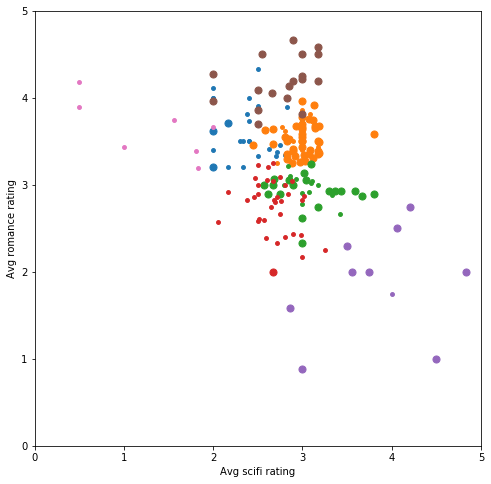

In [97]:
# TODO: Create an instance of KMeans to find seven clusters
kmeans_5 = KMeans(n_clusters=7)

# TODO: use fit_predict to cluster the dataset
predictions_5 = kmeans_5.fit_predict(X_with_action)

# plot
helper.draw_clusters_3d(biased_dataset_3_genres, predictions_5)

我们依然分别用 x 轴和 y 轴表示科幻片和爱情片。并用点的大小大致表示动作片评分情况（更大的点表示平均评分超过 3 颗星，更小的点表示不超过 3 颗星 ）。

可以看出添加类型后，用户的聚类分布发生了变化。为 k 均值提供的数据越多，每组中用户之间的兴趣越相似。但是如果继续这么绘制，我们将无法可视化二维或三维之外的情形。在下个部分，我们将使用另一种图表，看看多达 50 个维度的聚类情况。

## 电影级别的聚类
现在我们已经知道 k 均值会如何根据用户的类型品位对用户进行聚类，我们再进一步分析，看看用户对单个影片的评分情况。为此，我们将数据集构建成 userId 与用户对每部电影的评分形式。例如，我们来看看以下数据集子集：

In [98]:
# Merge the two tables then pivot so we have Users X Movies dataframe
ratings_title = pd.merge(ratings, movies[['movieId', 'title']], on='movieId' )
user_movie_ratings = pd.pivot_table(ratings_title, index='userId', columns= 'title', values='rating')

print('dataset dimensions: ', user_movie_ratings.shape, '\n\nSubset example:')
user_movie_ratings.iloc[:6, :10]

dataset dimensions:  (671, 9064) 

Subset example:


title,"""Great Performances"" Cats (1998)",$9.99 (2008),'Hellboy': The Seeds of Creation (2004),'Neath the Arizona Skies (1934),'Round Midnight (1986),'Salem's Lot (2004),'Til There Was You (1997),"'burbs, The (1989)",'night Mother (1986),(500) Days of Summer (2009)
userId,,,,,,,,,,
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN


<div>
<style>
    .dataframe thead tr:only-child th {
        text-align: right;
    }

NaN 值的优势表明了第一个问题。大多数用户没有看过大部分电影，并且没有为这些电影评分。这种数据集称为“稀疏”数据集，因为只有少数单元格有值。

为了解决这一问题，我们按照获得评分次数最多的电影和对电影评分次数最多的用户排序。这样可以形成更“密集”的区域，使我们能够查看数据集的顶部数据。

如果我们要选择获得评分次数最多的电影和对电影评分次数最多的用户，则如下所示：

In [99]:
n_movies = 30
n_users = 18
most_rated_movies_users_selection = helper.sort_by_rating_density(user_movie_ratings, n_movies, n_users)

print('dataset dimensions: ', most_rated_movies_users_selection.shape)
most_rated_movies_users_selection.head()

dataset dimensions:  (18, 30)


title,Forrest Gump (1994),Pulp Fiction (1994),"Shawshank Redemption, The (1994)","Silence of the Lambs, The (1991)",Star Wars: Episode IV - A New Hope (1977),Jurassic Park (1993),"Matrix, The (1999)",Toy Story (1995),Schindler's List (1993),Terminator 2: Judgment Day (1991),...,Dances with Wolves (1990),Fight Club (1999),"Usual Suspects, The (1995)",Seven (a.k.a. Se7en) (1995),"Lion King, The (1994)","Godfather, The (1972)","Lord of the Rings: The Fellowship of the Ring, The (2001)",Apollo 13 (1995),True Lies (1994),Twelve Monkeys (a.k.a. 12 Monkeys) (1995)
29,5.0,5.0,5.0,4.0,4.0,4.0,3.0,4.0,5.0,4.0,...,5.0,4.0,5.0,4.0,3.0,5.0,3.0,5.0,4.0,2.0
508,4.0,5.0,4.0,4.0,5.0,3.0,4.5,3.0,5.0,2.0,...,5.0,4.0,5.0,4.0,3.5,5.0,4.5,3.0,2.0,4.0
14,1.0,5.0,2.0,5.0,5.0,3.0,5.0,2.0,4.0,4.0,...,3.0,5.0,5.0,5.0,4.0,5.0,5.0,3.0,4.0,4.0
72,5.0,5.0,5.0,4.5,4.5,4.0,4.5,5.0,5.0,3.0,...,4.5,5.0,5.0,5.0,5.0,5.0,5.0,3.5,3.0,5.0
653,4.0,5.0,5.0,4.5,5.0,4.5,5.0,5.0,5.0,5.0,...,4.5,5.0,5.0,4.5,5.0,4.5,5.0,5.0,4.0,5.0


<div>
<style>
    .dataframe thead tr:only-child th {
        text-align: right;
    }

这样更好分析。我们还需要指定一个可视化这些评分的良好方式，以便在查看更庞大的子集时能够直观地识别这些评分（稍后变成聚类）。

我们使用颜色代替评分数字：

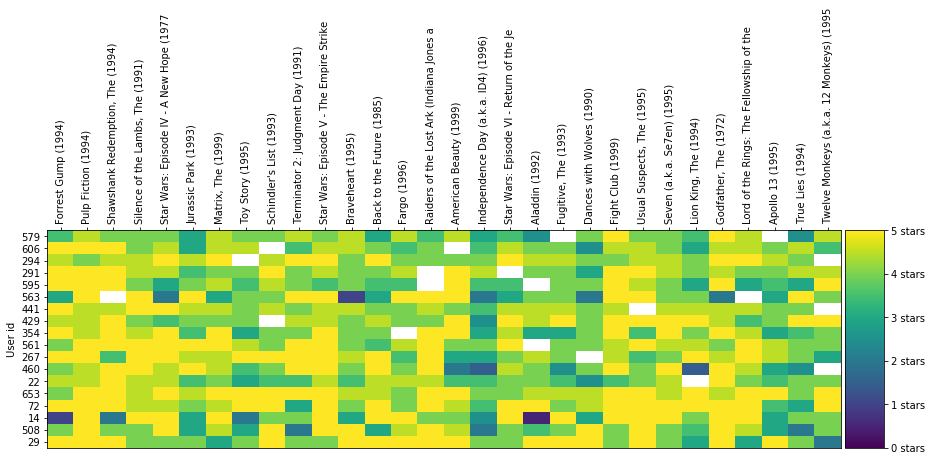

In [100]:
helper.draw_movies_heatmap(most_rated_movies_users_selection)

每列表示一部电影。每行表示一位用户。单元格的颜色根据图表右侧的刻度表示用户对该电影的评分情况。

注意到某些单元格是白色吗？表示相应用户没有对该电影进行评分。在现实中进行聚类时就会遇到这种问题。与一开始经过整理的示例不同，现实中的数据集经常比较稀疏，数据集中的部分单元格没有值。这样的话，直接根据电影评分对用户进行聚类不太方便，因为 k 均值通常不喜欢缺失值。

为了提高性能，我们将仅使用 1000 部电影的评分（数据集中一共有 9000 部以上）。

In [101]:
user_movie_ratings =  pd.pivot_table(ratings_title, index='userId', columns= 'title', values='rating')
most_rated_movies_1k = helper.get_most_rated_movies(user_movie_ratings, 1000)

为了使 sklearn 对像这样缺少值的数据集运行 k 均值聚类，我们首先需要将其转型为[稀疏 csr 矩阵](https://docs.scipy.org/doc/scipy-0.19.0/reference/generated/scipy.sparse.csr_matrix.html)类型（如 SciPi 库中所定义）。

要从 pandas dataframe 转换为稀疏矩阵，我们需要先转换为 SparseDataFrame，然后使用 pandas 的 `to_coo()` 方法进行转换。

注意：只有较新版本的 pandas 具有`to_coo()`。如果你在下个单元格中遇到问题，确保你的 pandas 是最新版本。

In [102]:
sparse_ratings = csr_matrix(pd.SparseDataFrame(most_rated_movies_1k).to_coo())

## 我们来聚类吧！
对于 k 均值，我们需要指定 k，即聚类数量。我们随意地尝试 k=20（选择 k 的更佳方式如上述肘部方法所示。但是，该方法需要一定的运行时间。):

In [103]:
# 20 clusters
predictions = KMeans(n_clusters=20, algorithm='full').fit_predict(sparse_ratings)

为了可视化其中一些聚类，我们需要将每个聚类绘制成热图：

cluster # 7
# of users in cluster: 245. # of users in plot: 70


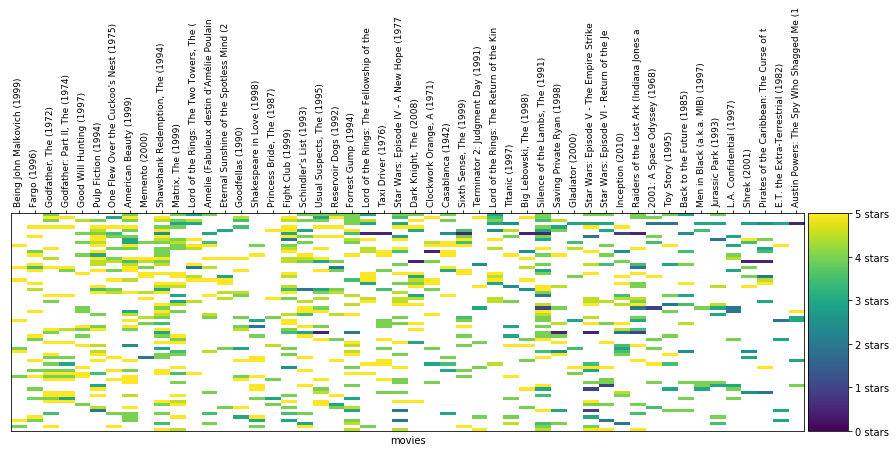

cluster # 14
# of users in cluster: 37. # of users in plot: 37


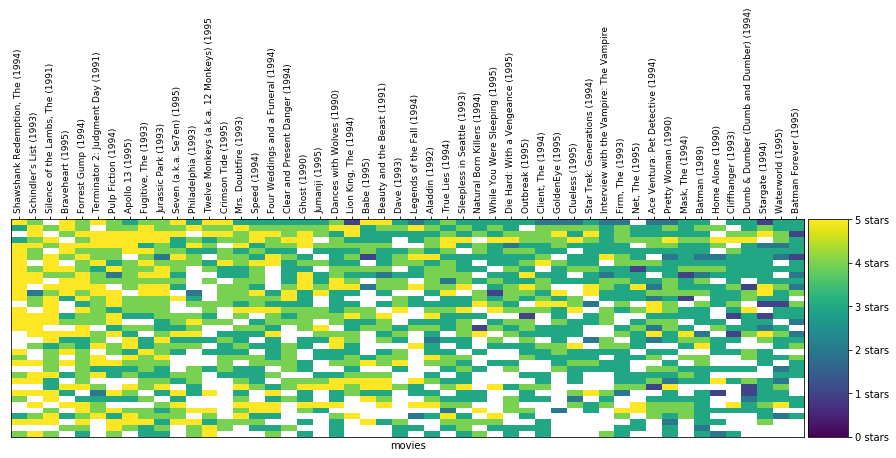

cluster # 2
# of users in cluster: 15. # of users in plot: 15


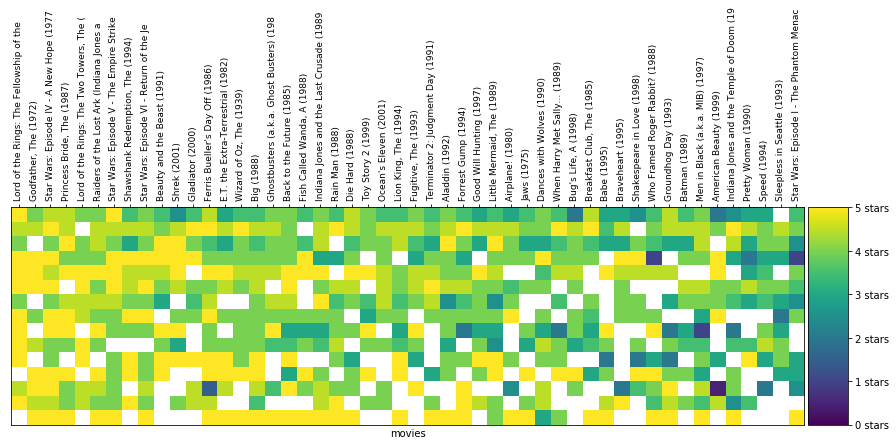

cluster # 12
# of users in cluster: 88. # of users in plot: 70


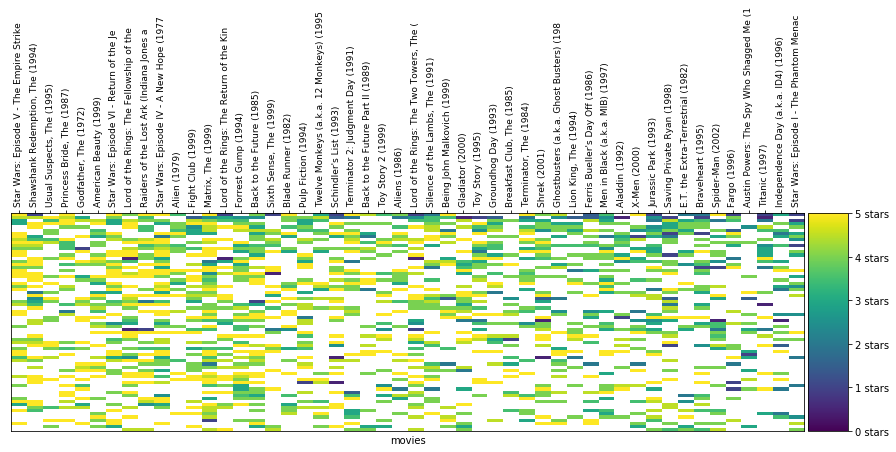

cluster # 13
# of users in cluster: 42. # of users in plot: 42


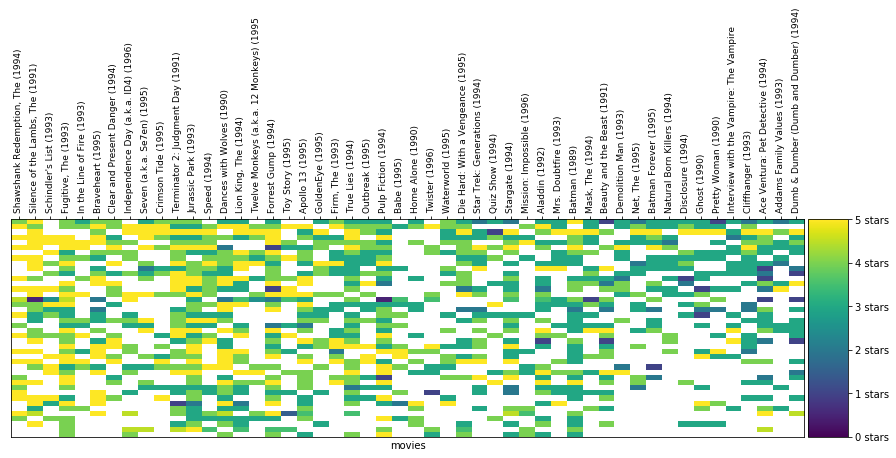

cluster # 0
# of users in cluster: 42. # of users in plot: 42


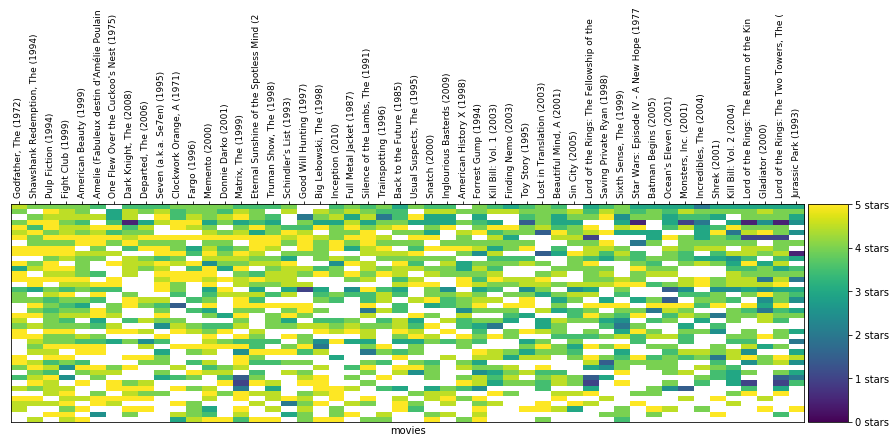

cluster # 11
# of users in cluster: 36. # of users in plot: 36


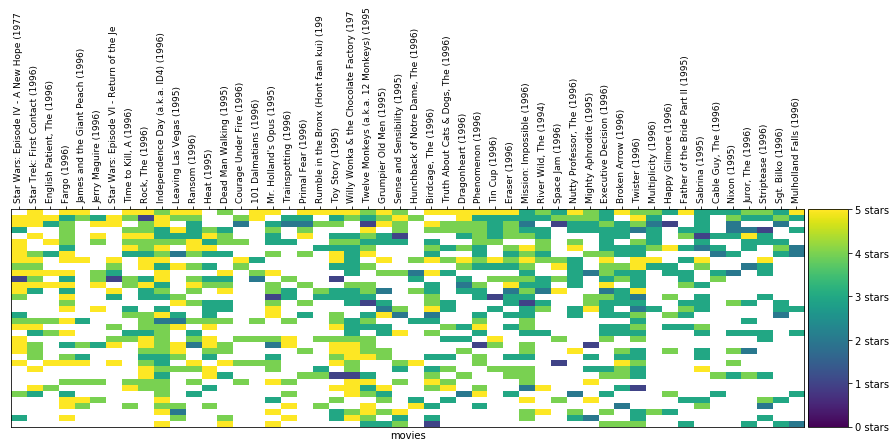

cluster # 16
# of users in cluster: 36. # of users in plot: 36


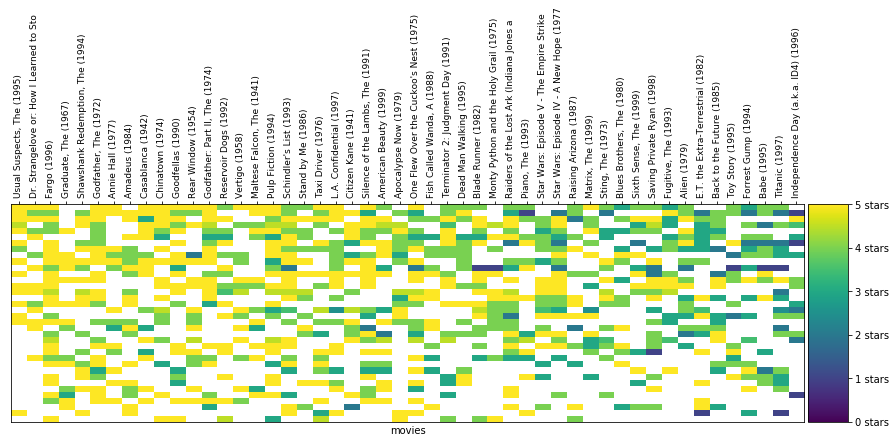

cluster # 19
# of users in cluster: 22. # of users in plot: 22


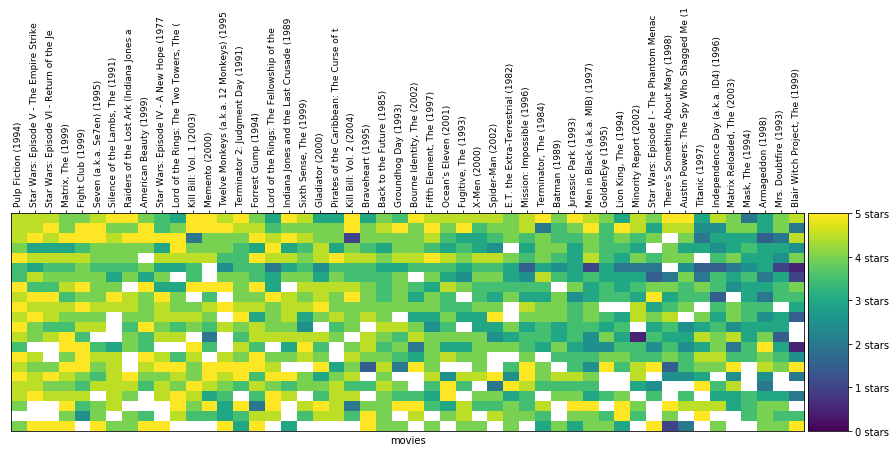

cluster # 1
# of users in cluster: 21. # of users in plot: 21


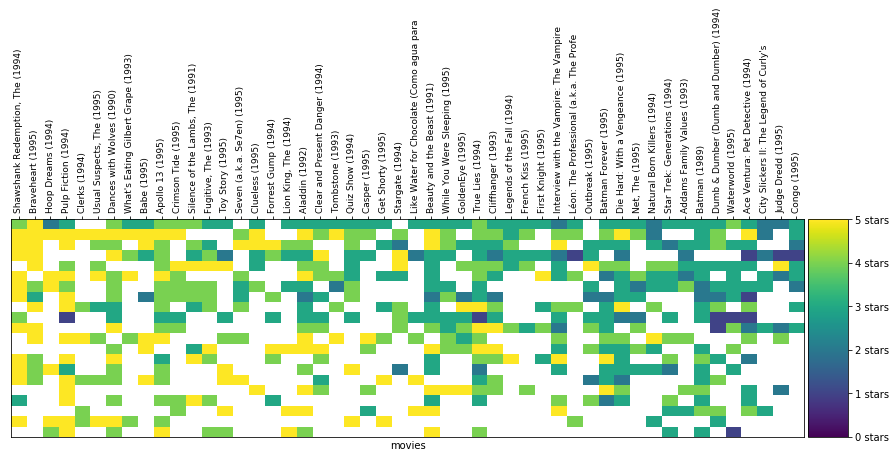

cluster # 6
# of users in cluster: 47. # of users in plot: 47


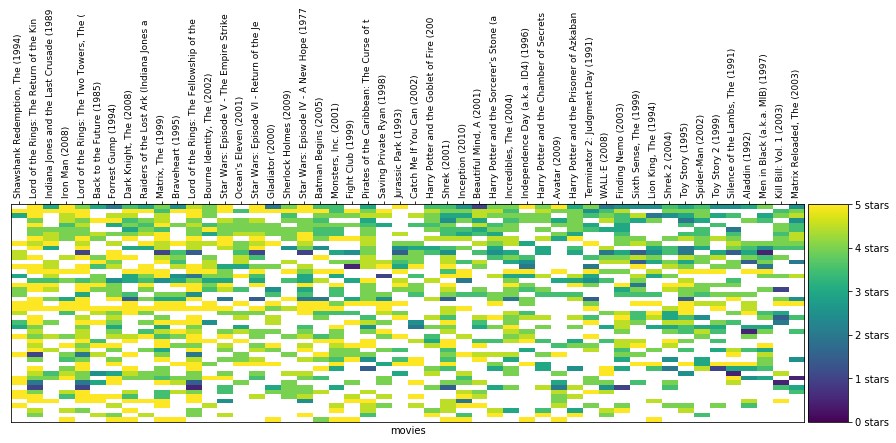

In [104]:
max_users = 70
max_movies = 50

clustered = pd.concat([most_rated_movies_1k.reset_index(), pd.DataFrame({'group':predictions})], axis=1)
helper.draw_movie_clusters(clustered, max_users, max_movies)

需要注意以下几个事项：

* 聚类中的评分越相似，你在该聚类中就越能发现颜色相似的**垂直**线。
* 在聚类中发现了非常有趣的规律：
 * 某些聚类比其他聚类更稀疏，其中的用户可能比其他聚类中的用户看的电影更少，评分的电影也更少。
 * 某些聚类主要是黄色，汇聚了非常喜欢特定类型电影的用户。其他聚类主要是绿色或海蓝色，表示这些用户都认为某些电影可以评 2-3 颗星。
 * 注意每个聚类中的电影有何变化。图表对数据进行了过滤，仅显示评分最多的电影，然后按照平均评分排序。
 * 能找到《指环王》在每个聚类中位于哪个位置吗？《星球大战》呢？
* 很容易发现具有相似颜色的**水平**线，表示评分变化不大的用户。这可能是 Netflix 从基于星级的评分切换到喜欢/不喜欢评分的原因之一。四颗星评分对不同的人来说，含义不同。
* 我们在可视化聚类时，采取了一些措施（过滤/排序/切片）。因为这种数据集比较“稀疏”，大多数单元格没有值（因为大部分用户没有看过大部分电影）。

## 预测
我们选择一个聚类和一位特定的用户，看看该聚类可以使我们执行哪些实用的操作。

首先选择一个聚类：

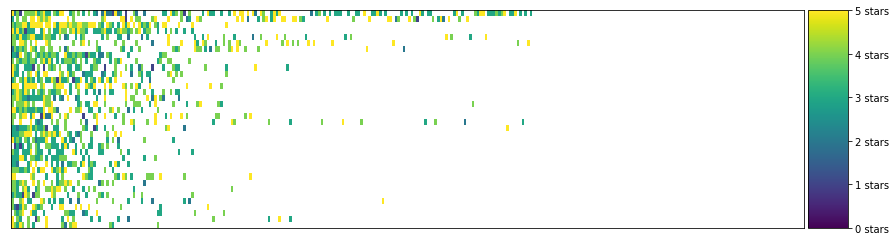

In [105]:
# TODO: Pick a cluster ID from the clusters above
cluster_number = 11

# Let's filter to only see the region of the dataset with the most number of values 
n_users = 75
n_movies = 300
cluster = clustered[clustered.group == cluster_number].drop(['index', 'group'], axis=1)

cluster = helper.sort_by_rating_density(cluster, n_movies, n_users)
helper.draw_movies_heatmap(cluster, axis_labels=False)

聚类中的实际评分如下所示：

In [106]:
cluster.fillna('').head()

,Independence Day (a.k.a. ID4) (1996),Mission: Impossible (1996),Twister (1996),Twelve Monkeys (a.k.a. 12 Monkeys) (1995),Willy Wonka & the Chocolate Factory (1971),"Rock, The (1996)",Executive Decision (1996),Fargo (1996),Toy Story (1995),"Birdcage, The (1996)",...,Midnight Cowboy (1969),"Thomas Crown Affair, The (1999)",Fried Green Tomatoes (1991),Lethal Weapon 3 (1992),Remember the Titans (2000),"Flintstones, The (1994)",What Lies Beneath (2000),Donnie Brasco (1997),Insomnia (2002),The Hunger Games (2012)
24,5,2,4,1,,4,4,4,4,5,...,,,,,,,,,,
30,3,,4,,4,4,,5,5,,...,,,,,,,,,,
4,4,3,4,4,5,5,3,5,5,5,...,,,,,,,,,,
22,5,3,5,3,4,1,3,3,3,,...,,,,,,,,,,
23,4,4,3,5,3,3,4,5,5,3,...,,,,,,,,,,


<div>
<style>
    .dataframe thead tr:only-child th {
        text-align: right;
    }

从表格中选择一个空白单元格。因为用户没有对该电影评分，所以是空白状态。能够预测她是否喜欢该电影吗？因为该用户属于似乎具有相似品位的用户聚类，我们可以计算该电影在此聚类中的平均评分，结果可以作为她是否喜欢该电影的合理预测依据。

In [107]:
# TODO: Fill in the name of the column/movie. e.g. 'Forrest Gump (1994)'
movie_name = "Forrest Gump (1994)"

cluster[movie_name].mean()

4.5

这就是我们关于她会如何对该电影进行评分的预测。

## 推荐
我们回顾下上一步的操作。我们使用 k 均值根据用户的评分对用户进行聚类。这样就形成了具有相似评分的用户聚类，因此通常具有相似的电影品位。基于这一点，当某个用户对某部电影没有评分时，我们对该聚类中所有其他用户的评分取平均值，该平均值就是我们猜测该用户对该电影的喜欢程度。

根据这一逻辑，如果我们计算该聚类中每部电影的平均分数，就可以判断该“品位聚类”对数据集中每部电影的喜欢程度。

In [108]:
# The average rating of 20 movies as rated by the users in the cluster
cluster.mean().head(20)

Independence Day (a.k.a. ID4) (1996)          3.970588
Mission: Impossible (1996)                    3.533333
Twister (1996)                                3.366667
Twelve Monkeys (a.k.a. 12 Monkeys) (1995)     3.714286
Willy Wonka & the Chocolate Factory (1971)    3.750000
Rock, The (1996)                              4.000000
Executive Decision (1996)                     3.461538
Fargo (1996)                                  4.269231
Toy Story (1995)                              3.760000
Birdcage, The (1996)                          3.666667
Broken Arrow (1996)                           3.391304
Phenomenon (1996)                             3.608696
Star Wars: Episode IV - A New Hope (1977)     4.363636
Mr. Holland's Opus (1995)                     3.863636
Ransom (1996)                                 3.904762
Heat (1995)                                   3.904762
Eraser (1996)                                 3.550000
Sabrina (1995)                                3.200000
Star Trek:

这对我们来说变得非常实用，因为现在我们可以使用它作为推荐引擎，使用户能够发现他们可能喜欢的电影。

当用户登录我们的应用时，现在我们可以向他们显示符合他们的兴趣品位的电影。推荐方式是选择聚类中该用户尚未评分的最高评分的电影。

In [109]:
# TODO: Pick a user ID from the dataset
# Look at the table above outputted by the command "cluster.fillna('').head()" 
# and pick one of the user ids (the first column in the table)
user_id = 19

# Get all this user's ratings
user_2_ratings  = cluster.loc[user_id, :]

# Which movies did they not rate? (We don't want to recommend movies they've already rated)
user_2_unrated_movies =  user_2_ratings[user_2_ratings.isnull()]

# What are the ratings of these movies the user did not rate?
avg_ratings = pd.concat([user_2_unrated_movies, cluster.mean()], axis=1, join='inner').loc[:,0]

# Let's sort by rating so the highest rated movies are presented first
avg_ratings.sort_values(ascending=False)[:20]

Manchurian Candidate, The (1962)                          5.0
Star Trek II: The Wrath of Khan (1982)                    5.0
Lion King, The (1994)                                     5.0
Seven (a.k.a. Se7en) (1995)                               5.0
Star Wars: Episode V - The Empire Strikes Back (1980)     5.0
Good Will Hunting (1997)                                  5.0
Schindler's List (1993)                                   5.0
Butch Cassidy and the Sundance Kid (1969)                 5.0
Pulp Fiction (1994)                                       5.0
To Kill a Mockingbird (1962)                              5.0
Grosse Pointe Blank (1997)                                5.0
Titanic (1997)                                            5.0
Wallace & Gromit: The Wrong Trousers (1993)               5.0
Snow White and the Seven Dwarfs (1937)                    5.0
Contact (1997)                                            5.0
Jurassic Park (1993)                                      5.0
Gandhi (

这些是向用户推荐的前 20 部电影！

### 练习：
 * 如果聚类中有一部电影只有一个评分，评分是 5 颗星。该电影在该聚类中的平均评分是多少？这会对我们的简单推荐引擎有何影响？你会如何调整推荐系统，以解决这一问题？

## 关于协同过滤的更多信息
* 这是一个简单的推荐引擎，展示了“协同过滤”的最基本概念。有很多可以改进该引擎的启发法和方法。为了推动在这一领域的发展，Netflix 设立了 [Netflix 奖项](https://en.wikipedia.org/wiki/Netflix_Prize) ，他们会向对 Netflix 的推荐算法做出最大改进的算法奖励 1,000,000 美元。
* 在 2009 年，“BellKor's Pragmatic Chaos”团队获得了这一奖项。[这篇论文](http://www.netflixprize.com/assets/GrandPrize2009_BPC_BigChaos.pdf)介绍了他们采用的方式，其中包含大量方法。
* [Netflix 最终并没有使用这个荣获 1,000,000 美元奖励的算法](https://thenextweb.com/media/2012/04/13/remember-netflixs-1m-algorithm-contest-well-heres-why-it-didnt-use-the-winning-entry/)，因为他们采用了流式传输的方式，并产生了比电影评分要庞大得多的数据集——用户搜索了哪些内容？用户在此会话中试看了哪些其他电影？他们是否先看了一部电影，然后切换到了其他电影？这些新的数据点可以提供比评分本身更多的线索。

## 深入研究

* 该 notebook 显示了用户级推荐系统。我们实际上可以使用几乎一样的代码进行商品级推荐。例如亚马逊的“购买（评价或喜欢）此商品的客户也购买了（评价了或喜欢）以下商品：” 。我们可以在应用的每个电影页面显示这种推荐。为此，我们只需将数据集转置为“电影 X 用户”形状，然后根据评分之间的联系对电影（而不是用户）进行聚类。
* 我们从数据集 Movie Lens 中抽取了最小的子集，只包含 100,000 个评分。如果你想深入了解电影评分数据，可以查看他们的[完整数据集](https://grouplens.org/datasets/movielens/)，其中包含 2400 万个评分。